In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from matplotlib import pyplot as plt
import pathlib
import glob 
import warnings
warnings.filterwarnings("ignore")

data_dir = '/kaggle/input/mango-leaf-disease-dataset'

2024-02-26 14:56:19.481296: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 14:56:19.481414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 14:56:19.790094: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCH = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4000 files belonging to 8 classes.


In [4]:
class_names = dataset.class_names
class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

In [5]:
len(dataset)      # 125*32 = 4000

125

(32, 224, 224, 3)
[7 2 4 1 1 3 3 5 5 1 7 0 5 7 0 5 4 4 1 4 5 2 3 1 0 1 0 6 0 1 0 0]


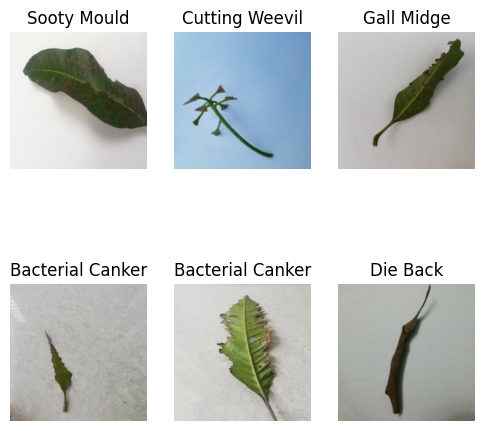

In [6]:
plt.figure(figsize=(6,6))
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())
    for i in range(6):
        ax = plt.subplot(2,3,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])

In [7]:
def get_tf_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle= True, shuffle_size=2000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=20)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_tf_dataset_partitions(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(600).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(600).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(600).prefetch(buffer_size=tf.data.AUTOTUNE)

<h4> Preprocessing </h4>

In [10]:
# resize and rescale layer

resize_and_scale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)    
])

In [11]:
# augmentation layer

data_augmentation = tf.keras.Sequential([
    
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=8

model = models.Sequential([
    resize_and_scale,
    data_augmentation,
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 111, 111, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 54, 54, 64)          0         
 g2D)                                                 

In [14]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [15]:
history = model.fit(train_ds,
         epochs=EPOCH,
         batch_size=BATCH_SIZE,
         verbose=1,
         validation_data=val_ds)

Epoch 1/30


I0000 00:00:1708959417.211118      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 25s 84ms/step - loss: 1.6335 - accuracy: 0.3400 - val_loss: 1.0417 - val_accuracy: 0.6458
Epoch 2/30
100/100 [==============================] - 4s 43ms/step - loss: 0.9451 - accuracy: 0.6472 - val_loss: 0.5958 - val_accuracy: 0.7708
Epoch 3/30
100/100 [==============================] - 4s 43ms/step - loss: 0.6691 - accuracy: 0.7522 - val_loss: 0.6756 - val_accuracy: 0.7109
Epoch 4/30
100/100 [==============================] - 4s 43ms/step - loss: 0.5489 - accuracy: 0.7925 - val_loss: 0.3864 - val_accuracy: 0.8516
Epoch 5/30
100/100 [==============================] - 4s 45ms/step - loss: 0.4463 - accuracy: 0.8300 - val_loss: 0.4217 - val_accuracy: 0.8229
Epoch 6/30
100/100 [==============================] - 4s 43ms/step - loss: 0.3545 - accuracy: 0.8794 - val_loss: 0.2329 - val_accuracy: 0.9193
Epoch 7/30
100/100 [==============================] - 4s 43ms/step - loss: 0.2841 - accuracy: 0.8997 - val_loss: 0.2425 - val_accuracy: 0.9089
Epoch 8/3

In [16]:
model.evaluate(test_ds)

13/13 [==============================] - 3s 20ms/step - loss: 0.0659 - accuracy: 0.9736


[0.06587418168783188, 0.973557710647583]

In [17]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation loss')

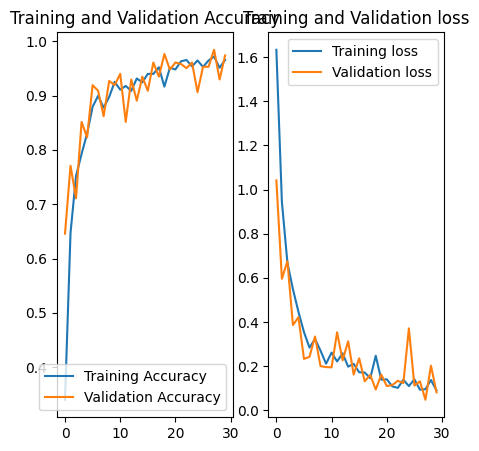

In [18]:
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCH), loss, label='Training loss')
plt.plot(range(EPOCH), val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

First image to predict
First image's label: Cutting Weevil
1/1 [==============================] - 0s 140ms/step
Predicted Label: Cutting Weevil


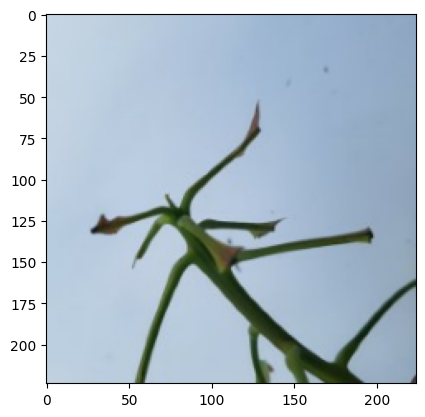

In [19]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print("First image's label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [20]:
def predict(model, img):
    
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    pred_class = class_names[np.argmax(predictions[0])]
    
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return pred_class, confidence

1/1 [==============================] - 0s 18ms/step


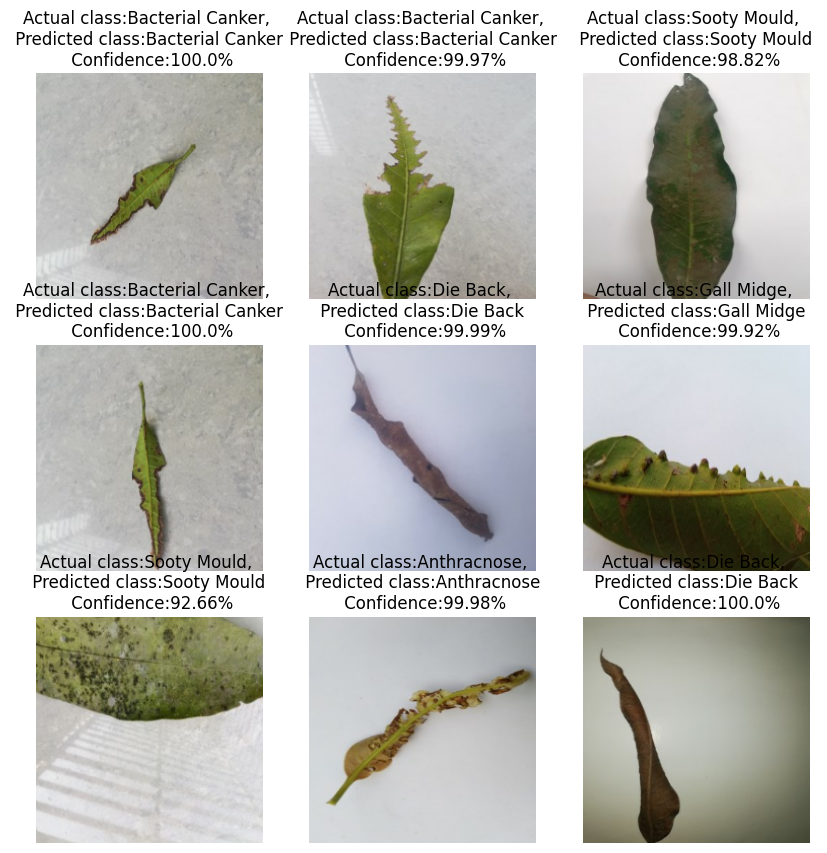

In [21]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i].numpy()]
        
        plt.title(f"Actual class:{actual_class}, \n Predicted class:{predicted_class} \n Confidence:{confidence}%")
        
        plt.axis('off')

In [22]:
model.save("mangoleaf.h5")